In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
print("Successfully imported libraries")

Successfully imported libraries


In [2]:
# Import all functions from the required modules
from pop_functions_module import *
print("Successfully loaded population functions")

Successfully loaded population functions


In [4]:
# Paths to data files
path_contours = "data/1-processed-data/CONTOURS-IRIS"
path_iris = "data/1-processed-data/INSEE/donnees_iris.txt"
path_proj = "data/1-processed-data/INSEE/donnees_projections.txt"
path_depart = "data/1-processed-data/INSEE/num_depart.csv"
path_age_femmes = "data/1-processed-data/INSEE/donnees_age_femmes.csv"
path_age_hommes = "data/1-processed-data/INSEE/donnees_age_hommes.csv"
path_mortalite_hf = "data/1-processed-data/INSEE/donnees_deces_hf.csv"
#path_pop_density = "data/1-processed-data/INSEE/donnees_dens.csv"

# EXPORT : paths and titles for exported data
path = "data/2-output-data"
path_fichier_shp = "data/2-output-data/donnees_shp"
path_fichier_shp_1 = "data/2-output-data/donnees_shp_1"
path_fichier_shp_2 = "data/2-output-data/donnees_shp_2"
path_fichier_shp_3 = "data/2-output-data/donnees_shp_3"
title_shp = "donnees_insee_iris"
title_shp_1 = "donnees_insee_iris_toutage_1"
title_shp_2 = "donnees_insee_iris_toutage_2"
title_shp_3 = "donnees_insee_iris_toutage_3"

In [5]:
donnees_geom = geometries(path_iris, path_depart, path_contours)
print("Top 2 rows of donnees_geom:")
print(donnees_geom.head())
age_hf = age_nat(path_age_femmes, path_age_hommes)
print("Top 2 rows of age_hf:")
print(age_hf.head())
perc_hf = decomposition_age(age_hf)
print("All columns of perc_hf:")
print(perc_hf.columns)
print("Top 2 rows of perc_hf:")
print(perc_hf.head())
pd.set_option('display.max_columns', None)  # Ensures all columns are shown
donnees_proj = recense(path_proj, perc_hf)
print("Top 2 rows of donnees_proj:")
print(donnees_proj.head())
donnees_insee = desagreg(donnees_geom, donnees_proj)
print("Top 2 rows of donnees_insee:")
print(donnees_insee.head())
donnees_dens = dens(donnees_insee)
print("Top 2 rows of donnees_dens:")
print(donnees_dens.head())
donnees_finales = mortalite(donnees_dens, path_mortalite_hf)
print("Top 2 rows of donnees_finales:")
print(donnees_finales.head())
donnees_filtrees = create_donnees_shp(donnees_finales)

The INSEE data is extracted at the IRIS level.
Top 2 rows of donnees_geom:
  dep_cod        dep_name  region_cod       region_name com_cod  com_name  \
0      72          Sarthe          52  Pays de la Loire   72191     Mayet   
1      77  Seine-et-Marne          11     Ile-de-France   77248   Lesches   
2      51           Marne          44         Grand Est   51426      Péas   
3      81            Tarn          76         Occitanie   81199    Padiès   
4      59            Nord          32   Hauts-de-France   59225  Feignies   

    iris_cod iris_name  POP_2019_IRIS_TotAge  \
0  721910000     Mayet                  3120   
1  772480000   Lesches                   763   
2  514260000      Péas                    66   
3  811990000    Padiès                   189   
4  592250102       Sud                  2479   

                                            geometry       aire_m2  
0  POLYGON ((497887.4 6747662.4, 497907.2 6747658...  5.418802e+07  
1  POLYGON ((685757.7 6868592.3, 68

In [4]:
# Function to export data for the years 2019, 2030, and 2050
def export_pollution(donnees_filtrees):
    # Ensure the 'age' column is numeric for filtering purposes
    donnees_filtrees["age"] = pd.to_numeric(donnees_filtrees["age"], errors="coerce")
    # Drop geometry and select specific columns for indicators
    donnees_indic = (
        donnees_geom.drop(columns="geometry")
        .loc[:, ["iris_cod", "iris_name", "com_cod", "com_name", "dep_cod", "dep_name", "region_cod", "region_name"]]
        .rename(columns={
            "region_cod": "regcod",
            "region_name": "regname",
            "iris_cod": "iriscod",
            "iris_name": "irisname",
            "com_cod": "comcod",
            "com_name": "comname",
            "dep_cod": "depcod",
            "dep_name": "depname"
        })
    )

    # Filter by age and group by 'iriscod', then aggregate population and mortality data
    donnees_pop = (
        donnees_filtrees[donnees_filtrees["age"] >= 30]
        .groupby("iriscod", as_index=False)  # Ensure 'iriscod' is kept as a column for the merge
        .agg(
            pop2019=("pop2019", lambda x: x.sum(skipna=True)),
            pop2030=("pop2030", lambda x: x.sum(skipna=True)),
            pop2050=("pop2050", lambda x: x.sum(skipna=True)),
            mort2019=("mort2019", lambda x: x.sum(skipna=True)),
            mort2030=("mort2030", lambda x: x.sum(skipna=True)),
            mort2050=("mort2050", lambda x: x.sum(skipna=True))
        )
    )

    # Merge the population/mortality data with geographic indicators
    donnees_shp = pd.merge(donnees_pop, donnees_indic, on="iriscod", how="inner")
    return donnees_shp

In [5]:
donnees_shp = export_pollution(donnees_filtrees)
donnees_shp_1 = donnees_filtrees.query("age >= 30 & age <= 55").loc[:, [
    "iriscod", "irisname", "comcod", "comname", "depcod", "depname", "regcod", "regname", "age",
    "pop2019", "pop2030", "pop2050", "mort2019", "mort2030", "mort2050"
]]

donnees_shp_2 = donnees_filtrees.query("age >= 56 & age <= 87").loc[:, [
    "iriscod", "irisname", "comcod", "comname", "depcod", "depname", "regcod", "regname", "age",
    "pop2019", "pop2030", "pop2050", "mort2019", "mort2030", "mort2050"
]]

donnees_shp_3 = donnees_filtrees.query("age >= 88 & age <= 99").loc[:, [
    "iriscod", "irisname", "comcod", "comname", "depcod", "depname", "regcod", "regname", "age",
    "pop2019", "pop2030", "pop2050", "mort2019", "mort2030", "mort2050"
]]

#export_data_shp(donnees_shp, path_fichier_shp, title_shp)
#export_data_shp(donnees_shp_1, path_fichier_shp_1, title_shp_1)
#export_data_shp(donnees_shp_2, path_fichier_shp_2, title_shp_2)
#export_data_shp(donnees_shp_3, path_fichier_shp_3, title_shp_3)

# Functions for exportation
title_csv = "my_data_file"
#export_data_csv(donnees_finales, path, title_csv)
#export_data_shp(donnees_indic, path_fichier_shp, title_shp)
#donnees_exportees = gpd.read_file(os.path.join(path_fichier_shp_1, f"{title_shp_1}.shp"))
#print(donnees_exportees.head())


The total population of all IRIS in 2030 is: 65264509.07910068.
The population of France in 2030 is: 68499605.
The total mortality of all IRIS in 2030 is: 2183348.285732827.
The mortality in France in 2030 is: 1359004.
The total population of the IRIS in department 01 in 2030 is: 701817.5900988703.
The population of the department 01 in 2030 is: 702280.0.
The total population of IRIS 861230000 in 2019 is: 3073.5280976555296.
The population of IRIS 861230000 in 2019 is: 3073.
The total population of the IRIS in department 67 in 2019 is: 1140162.3842620947.
The population of the department 67 in 2019 is: 1137600.0.


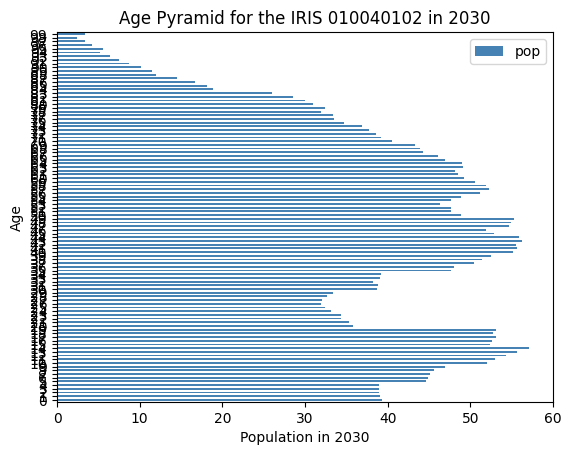

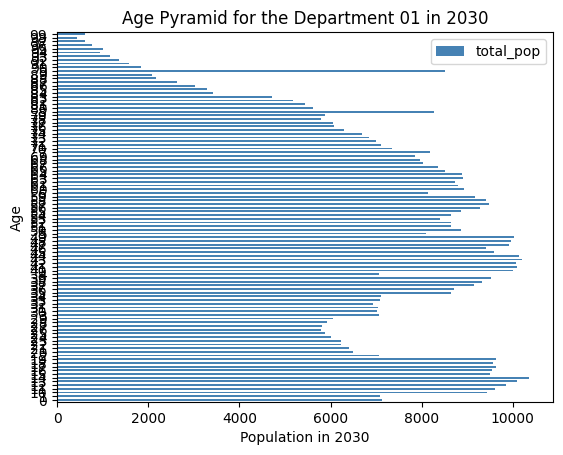

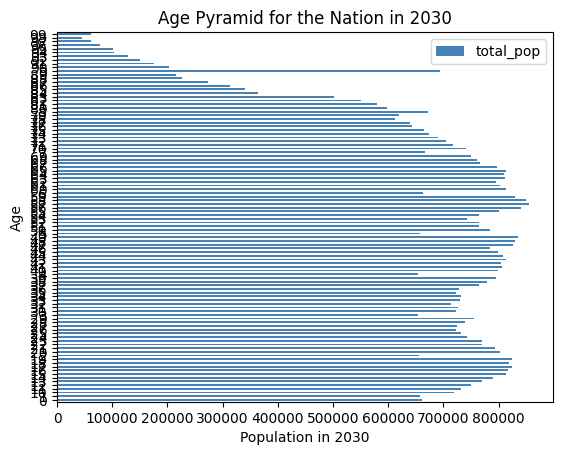

In [8]:
# Functions to test
annee = 2030
dep_num = "75"
iris_num = "010040102"
n = 35
national_vivant_test(donnees_finales, annee)
national_mort_test(donnees_finales, annee)
departemental_test(donnees_finales, dep_num, annee)
iris_test(donnees_finales)
dep_vs_iris_test(donnees_finales)
pyramide_iris(donnees_insee, iris_num, annee)
pyramide_dep(donnees_insee, dep_num, annee)
pyramide_nat(donnees_insee, annee)

In [ ]:
#Code to classify data into Urban vs Rural
# Step 1: Aggregate IRIS-level data to commune level (by "comcod")
commune_level_data = (
    donnees_exportees.groupby("comcod")
    .agg(
        pop2019=("pop2019", "sum"),
        pop2030=("pop2030", "sum"),
        pop2050=("pop2019", "sum"),
        area=("geometry", lambda x: x.union_all().area),  # Compute total area by unioning geometries
        geometry=("geometry", lambda x: x.union_all())  # Combine geometries to create commune-level geometry
    )
    .reset_index()
)

# Step 2: Calculate population density at the commune level
commune_level_data["pop_density"] = commune_level_data["pop2030"] / (commune_level_data["area"] / 1e6)

# Debugging: Display the first few rows of commune-level data
print("Head of commune-level data:")
print(commune_level_data.head())

# Step 3: Classify communes into "Urban" or "Rural" clusters
def classify_area_clusters(row):
    if row["pop_density"] > 1500:
        if row["pop2019"] >= 50000 or (5000 <= row["pop2019"] < 50000):
            return "Urban"  # Merge all Dense Urban levels into Urban
    elif row["pop_density"] > 300 and row["pop2019"] >= 5000:
        return "Urban"  # Include Semi-Dense Urban in Urban category
    else:
        return "Rural"  # Merge Rural and Other together

# Apply classification to the commune-level data
commune_level_data["area_cluster"] = commune_level_data.apply(classify_area_clusters, axis=1)

# Step 4: Debugging - Count clusters after classification
print(f"Clusters at the commune level:\n{commune_level_data['area_cluster'].value_counts()}")

# Step 5: Disaggregate classification back to the IRIS level
# Merge commune-level results (area_cluster, pop_density) back to the IRIS-level data
donnees_exportees_transformed = donnees_exportees.merge(
    commune_level_data[["comcod", "area_cluster", "pop_density"]],
    on="comcod",  # Match by the commune code
    how="left"  # Retain all IRIS-level data
)

# Step 6: Debugging - Display the first few rows of the disaggregated data
print("Head of IRIS-level data with disaggregated classification:")
print(donnees_exportees_transformed.head())